In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten, Activation
from keras.layers import Conv2D,MaxPooling2D, BatchNormalization
import os

import os
import pandas as pd
import cv2  # OpenCV ou cv2 para tratamento de imagens;
import numpy as np  # Numpy para trabalharmos com matrizes n-dimensionais
from keras.layers import Rescaling  # Camada de escalonamento
from keras.optimizers.legacy import Adam  # optimizador Adam
from tensorflow.data import AUTOTUNE

from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt




In [5]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU encontrada:", gpu)
    tf.config.experimental.set_memory_growth(gpus[0], True)  # Configuração para alocação dinâmica de memória
else:
    print("Nenhuma GPU disponível.")



Nenhuma GPU disponível.


In [3]:
train_path = "./../data/fer2013/train/"
models_path = "./models"

width = 48  
height = 48 
depth = 1  
classes = 7

epochs = 25
init_lr = 1e-3
batch_size = 32

input_shape = (height, width, depth)
save_model = os.path.join(
        models_path, "lenet-{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}.model")

In [4]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

def getModel():
    inputs = tf.keras.layers.Input(shape=(width, width, 3))
    base = tf.keras.applications.ResNet50(weights="imagenet", input_tensor=inputs, include_top=False)
    
    dense_regularizer = regularizers.l2(0.01)
    
    #base.trainable = False
    model = tf.keras.layers.Flatten()(base.output)
    model = tf.keras.layers.Dense(300, activation='relu', kernel_regularizer=dense_regularizer)(model)
    model = BatchNormalization()(model)
    model = tf.keras.layers.Dropout(0.2)(model)
    
    model = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=dense_regularizer)(model)
    model = BatchNormalization()(model)
    model = tf.keras.layers.Dropout(0.1)(model)
    
    model = tf.keras.layers.Dense(7, activation='softmax')(model)
    return tf.keras.Model(inputs, model)

In [8]:
getModel().summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [32]:
os.makedirs(models_path, exist_ok=True)

In [5]:
train_ds = image_dataset_from_directory(
        train_path,
        seed=123,
        label_mode='categorical',
        validation_split=0.2,
        subset="training",
        image_size=(height, width),
        batch_size=batch_size
    )

val_ds = image_dataset_from_directory(
    train_path,
    seed=123,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    image_size=(height, width),
    batch_size=batch_size
) 

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [8]:
rescaling_layer = Rescaling(1./255)
# pré-busca em buffer para que você possa produzir dados do disco sem que a E/S se torne um bloqueio
train_ds = train_ds.map(lambda x, y: (
    rescaling_layer(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (rescaling_layer(x), y),
                    num_parallel_calls=AUTOTUNE)


In [7]:
model = getModel()

In [9]:
opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(loss="categorical_crossentropy",
                  optimizer=opt, metrics=["accuracy"])

c:\Python310\lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [38]:
checkpoint1 = ModelCheckpoint(
    save_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint(
    save_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1, checkpoint2]

In [10]:
H = model.fit(train_ds,
                  validation_data=val_ds,
                  epochs=epochs,
                  verbose=1,
                  )



Epoch 1/25


  3/718 [..............................] - ETA: 36:16 - loss: 10.0556 - accuracy: 0.0833

KeyboardInterrupt: 

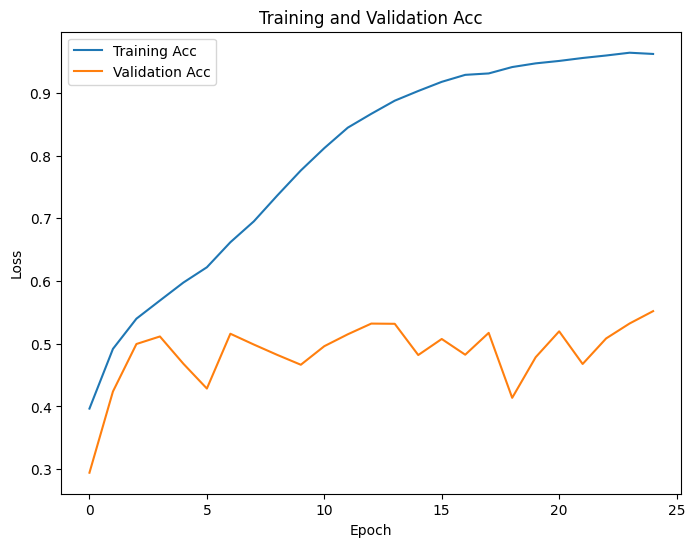

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(H.history['accuracy'], label='Training Acc')
plt.plot(H.history['val_accuracy'], label='Validation Acc')
plt.title('Training and Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
report = H.history
report

{'loss': [3.4380605220794678,
  1.5179619789123535,
  1.312744379043579,
  1.2382290363311768,
  1.1690698862075806,
  1.0995757579803467,
  1.004339337348938,
  0.917796790599823,
  0.8104926943778992,
  0.701362133026123,
  0.6028088927268982,
  0.5220671892166138,
  0.4536207318305969,
  0.3890983760356903,
  0.3374619483947754,
  0.2981177270412445,
  0.26378071308135986,
  0.26121729612350464,
  0.2249569445848465,
  0.2118985801935196,
  0.19879388809204102,
  0.175980806350708,
  0.16805976629257202,
  0.14685828983783722,
  0.15488934516906738],
 'accuracy': [0.39650818705558777,
  0.4917711615562439,
  0.5399686694145203,
  0.5689219832420349,
  0.597614049911499,
  0.6219958066940308,
  0.6619209051132202,
  0.6952716708183289,
  0.7365900278091431,
  0.7764281034469604,
  0.8120864033699036,
  0.8447405099868774,
  0.8668146729469299,
  0.887800395488739,
  0.9032567143440247,
  0.9178422093391418,
  0.9289881587028503,
  0.9312521815299988,
  0.9414402842521667,
  0.9473180

In [17]:
report = pd.DataFrame(report)
report

,loss,accuracy,val_loss,val_accuracy
0,3.438061,0.396508,2.041300,0.294200
1,1.517962,0.491771,1.641885,0.423794
2,1.312744,0.539969,1.406980,0.499565
3,1.238229,0.568922,1.358309,0.511583
4,1.169070,0.597614,1.479050,0.468037
5,1.099576,0.621996,1.553817,0.428497
6,1.004339,0.661921,1.407030,0.515938
7,0.917797,0.695272,1.570687,0.498694
8,0.810493,0.736590,1.619035,0.482146
9,0.701362,0.776428,1.745768,0.466469


In [18]:
val_predictions = model.predict(val_ds)
val_true_labels = []
for images, labels in val_ds:
    val_true_labels.extend(tf.argmax(labels, axis=1).numpy())

val_pred_labels = tf.argmax(val_predictions, axis=1).numpy()


180/180 [==============================] - 40s 213ms/step


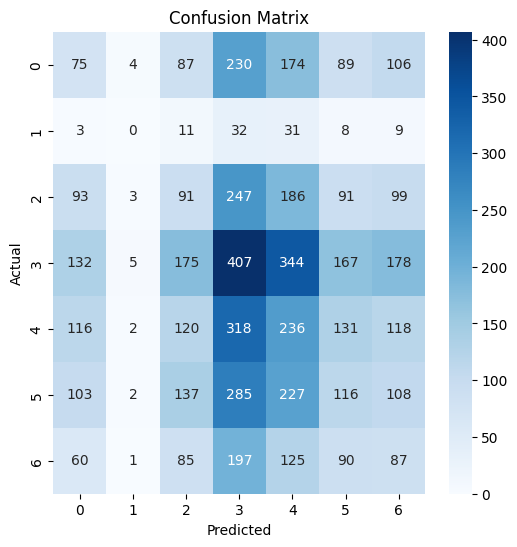

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
report = classification_report(val_true_labels, val_pred_labels, target_names=[str(i) for i in range(classes)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.13      0.10      0.11       765
           1       0.00      0.00      0.00        94
           2       0.13      0.11      0.12       810
           3       0.24      0.29      0.26      1408
           4       0.18      0.23      0.20      1041
           5       0.17      0.12      0.14       978
           6       0.12      0.13      0.13       645

    accuracy                           0.18      5741
   macro avg       0.14      0.14      0.14      5741
weighted avg       0.17      0.18      0.17      5741

